## Decision Tree

**Decision Trees**  are a very important ML method. **Decision trees** by themselves suffer from high variance, but they form the basis of some of the most powerful ML algorithms like **Random Forest**, **AdaBoosting** and **Gradient Boosting**. 
In this notebook we will implement **Decision trees** from scratch. **Decision trees** can be used for both **regression** and **classification**, difference between these two uses of **Decision trees** is the splitting criteria.

#### Decision Trees for Regression 

Say our data consists of $m$ inputs and a response for each of the $n$ observations, that is $(x_i, y_i)$. The decision tree algorithm needs to decide the splitting variables and splitting points. Suppose we partition the whole data in $R$ regions and in each region we model the response as an average response for that region ($c_r$). Then the regression function is given as $f(x) = \sum_{i=1}^{R}c_r \mathcal{I}(x \in R_r)$. 

Goal is to minimize $\mathcal{L} = \sum_{r=1}^{R}\sum_{i \in R_r} (y_i - \hat{y}_{R_r})^2$. Where $\hat{y}_{R_r}$ is the prediction for the region $R_r$.

It is not feasible to find the most optimal cut of the tree in a reasonable time, if there are $m$ inputs and $n$ observations there are a total of $m^n$ cuts possible which is infeasible to evaluate for any reasonably large $m$ and $n$. Hence **Decision tree** algorithms use a greedy approach. At each step of the tree building algorithm the best cut is made at that particular point rather than looking ahead and picking a cut which will make a better tree in some future step.
At any given step a cut is made which will minimize the loss most, i.e. we find split variable $j$ and split point $s$  such that the quantity in the bracket is minimized: 

$\text{min}_{j,s} \left [ \sum_{x_i \in R_1} (y_i - c_1)^2  + \sum_{x_i \in R_2} (y_i - c_2)^2 \right ]$

Clearly if we put every tree in its own node then the loss function will be zero. But that would lead to massive overfitting of the data. In practice we split until a certain debt of until a small number of points are left in the nodes. Also some pruning strategies are employed to regularize the trees.

Below we will implement **Decision Tree** for **Regression**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Make the sheet width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>" ))

In [2]:
#Implement regression and classification decision tree
from collections import Counter
class DT:
    """
    Implementation of a decision tree for regression and classification
    """
    class Node:
        xIndex = None
        xSplitPoint = None
        value = None
        leftNode = None
        rightNode = None
        mse = None
        nSamples = None
        
    root = Node()
    def __init__(self, minDataPoints=2, regressionTree=True):
        self.minDataPoints = minDataPoints
        self.regressionTree = regressionTree
    
    def fit(self, x, y):
        self._split(x, y, self.root, self.minDataPoints, self.regressionTree)
    
    def predict(self, x):
        return DT._predict(self.root, x)
        
    def print(self):
        DT._print(self.root,"")
        
    @staticmethod 
    def _predict(node, x):
        if (node.leftNode == None) :
            return node.value
        elif (x[node.xIndex] <= node.xSplitPoint):
            return DT._predict(node.leftNode, x)
        else:
            return DT._predict(node.rightNode, x)
    
    @staticmethod
    def _print(node, indent):
        if (node.leftNode == None) :
            print(f"{indent}value={node.value:.3}, mse={node.mse:.3}, nsamples={node.nSamples}")
        else:
            print(f"{indent}x[{node.xIndex}]={node.xSplitPoint:.3}, value={node.value:.3}, mse={node.mse:.3}, nsamples={node.nSamples}")
            indent += " "
            DT._print(node.leftNode, indent)
            DT._print(node.rightNode, indent)
        
    
    @staticmethod
    def _split(x, y, node, minDataPoints, regressionTree):
        if regressionTree:
            node.value = np.mean(y)
            node.mse = np.sum(np.square(y - node.value))/y.shape[0]
        else:
            ncount = Counter(y)
            node.value = float(ncount.most_common(1)[0][0])
            node.mse = DT._gini(y)
            
        node.nSamples = y.shape[0]
        if not regressionTree and node.mse == 0:
            return
        
        if (y.shape[0]  < minDataPoints):
            return
        else:
            (x_index, x_point) = DT._findBestSplit(x, y, regressionTree)
            y_left = y[x[:,x_index] <= x_point]
            y_right = y[x[:,x_index] > x_point]
            x_left = x[x[:,x_index] <= x_point]
            x_right = x[x[:,x_index] > x_point]
            if (y_left.shape[0] == 0) or (y_right.shape[0] == 0):
                return
            node.xIndex = x_index
            node.xSplitPoint = x_point
            node.leftNode = DT.Node()
            node.rightNode = DT.Node()
            DT._split(x_left, y_left, node.leftNode, minDataPoints, regressionTree)
            DT._split(x_right, y_right, node.rightNode, minDataPoints, regressionTree)
    
    @staticmethod
    def _findBestSplit(x, y, regressionTree):
        nx = x.shape[1]
        bestXIndex = -1
        bestSplitPoint = -1
        bestLoss = float("inf")
        for i in range(nx):
            xSortNdx = np.argsort(x[:,i])
            xSort = x[xSortNdx,i]
            ySort = y[xSortNdx]
            if regressionTree:
                z = DT._calculateRegressionLoss( xSort, ySort )
            else:
                z = DT._calculateClassificationGiniLoss( xSort, ySort)
            l = np.min(z)
            if l < bestLoss:
                bestSplitPoint = (xSort[np.argmin(z)] + xSort[np.argmin(z)+1])/2.0
                bestLoss = l
                bestXIndex = i
            
        return (bestXIndex, bestSplitPoint)
    
    @staticmethod
    def _calculateRegressionLoss(x, y):
        """
        Given a sorted x returns a vector of Loss if split by x_i
        Note this code can be optimized significantly but here we are writing for understanding 
        not speed
        """
        N = x.shape[0]
        l = np.zeros(N-1)
        for i in range(1, N):
            mean1 = np.mean(y[0:i])
            mean2 = np.mean(y[i:])
            l1 = np.sum(np.square(y[0:i] - mean1))
            l2 = np.sum(np.square(y[i:] - mean2))
            l[i-1] = l1 + l2
        return l
    
    @staticmethod
    def _gini(y):
        classes = np.unique(y)
        g = 0
        N = len(y)
        for c in classes:
            p = len(y[y==c])/N
            g += p * (1 - p)
        return g
        
    @staticmethod
    def _calculateClassificationGiniLoss(x, y):
        """
        Given a sorted x returns a vector of loss if split by x_i
        """
        N = x.shape[0]
        l = np.zeros(N-1)
        for i in range(1, N):
            gini1 = DT._gini(y[0:i])
            gini2 = DT._gini(y[i:])
            l[i-1] = gini1 + gini2
        return l
        
    

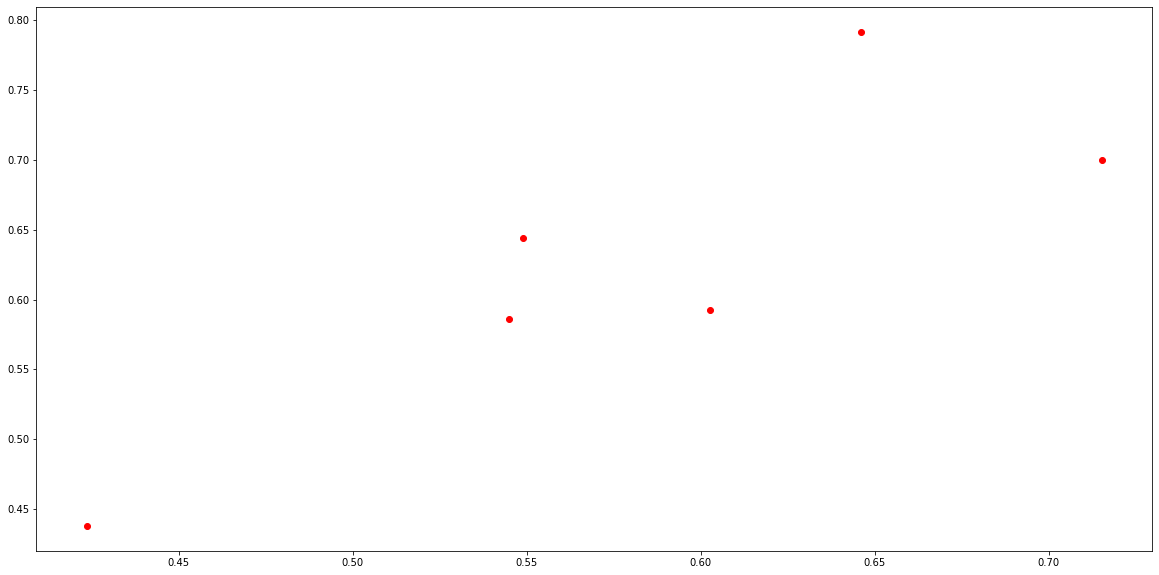

In [3]:
#Generate some test data and test the tree
np.random.seed(0)
x = np.random.uniform(size=(6,1))
y = x + np.random.randn(6,1)*0.1
plt.figure(figsize=(20,10))
plt.plot(x,y, 'ro')

In [4]:
#Fit the tree
dt = DT()
dt.fit(x,y)

#Print the tree
dt.print()

#Predict the tree
print(f"Predict={dt.predict(np.array([0.5])):.4}")

x[0]=0.624, value=0.625, mse=0.0119, nsamples=6
 x[0]=0.484, value=0.565, mse=0.00588, nsamples=4
  value=0.438, mse=0.0, nsamples=1
  x[0]=0.547, value=0.607, mse=0.00067, nsamples=3
   value=0.586, mse=0.0, nsamples=1
   x[0]=0.576, value=0.618, mse=0.00066, nsamples=2
    value=0.644, mse=0.0, nsamples=1
    value=0.592, mse=0.0, nsamples=1
 x[0]=0.681, value=0.746, mse=0.00208, nsamples=2
  value=0.791, mse=0.0, nsamples=1
  value=0.7, mse=0.0, nsamples=1
Predict=0.5859


Predict=[0.58594303]


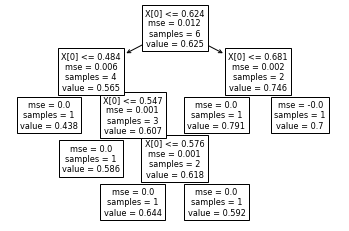

In [5]:
#Now lets compare with tree implementation of sklearn
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(x, y)
tree.plot_tree(clf)
print(f"Predict={clf.predict(np.array([0.5]).reshape(1,1))}")

#### Our tree implementation and sklearn implementation give similar results.

### Decision trees for classification

**Decision trees** can be used for classification also. For classification we just have to change the loss function. There are two most popular loss functions for classification. 
1. **Gin Index** - Lets define $p_{mk} = \frac{1}{N_m}\sum_{x_i \in R_m} \mathcal{I}(y_i = k)$. Proportion of class $k$ observations in node $m$. Then **Gini Index** is $\sum_{k=1}^{K} p_{mk}(1-p_{mk})$ where $K$ is the number of classes.
2. **Cross Entropy** - $-\sum_{k=1}^{K}p_{mk}\text{log}p_{mk}$

In practice both **Gini Index** and **Cross Entropy** give very similar results.


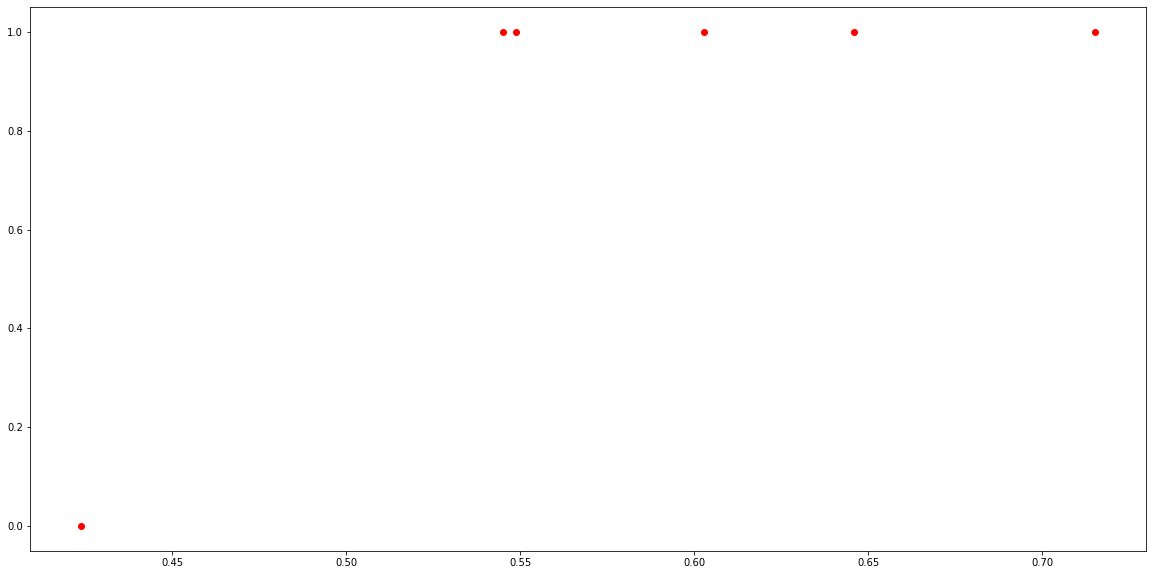

In [6]:
#Generate some test data and test the tree
np.random.seed(0)
x= np.random.uniform(size=(6,1))
y = np.array([ 1 if xi >= 0.5 else 0 for xi in x])
plt.figure(figsize=(20,10))
plt.plot(x,y, 'ro')

In [7]:
#Fit the tree
dtc = DT(regressionTree=False)
dtc.fit(x,y)

#Print the tree
dtc.print()

#Predict the tree
print(f"Predict={dtc.predict(np.array([0.6]))}")

x[0]=0.484, value=1.0, mse=0.278, nsamples=6
 value=0.0, mse=0.0, nsamples=1
 value=1.0, mse=0.0, nsamples=5
Predict=1.0


Predict=[1]


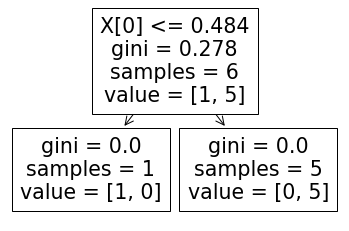

In [8]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(x, y)
tree.plot_tree(clf)
print(f"Predict={clf.predict(np.array([0.5]).reshape(1,1))}")

#### From the above we can see classification tree also matches with sklearn.